## Final Project Submission

* Student name: Hoang Nguyen, Madoria Thomas, Marcelo Scatena
* Student pace: full time
* Scheduled project review date: 07/01/2021
* Instructor name: Skyler English


In [1]:
pip install geopy

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels
from statsmodels.formula.api import ols
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.datasets import make_classification
from sklearn.metrics import mean_squared_error
#from ipynb.fs.full.cleaning_data import clean_data
from geopy import distance
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('data/kc_house_data.csv')

In [4]:
df_ref = pd.read_csv('data/kc_house_data.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

### Split Data into Test and Train

In [6]:
X = df.drop('price', axis=1)
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=42)

In [7]:
# We'll use df as our train dataset
y = y_train
X_train['price'] = y
df = X_train

### Find out where my missing values and fill them to make a first model with all the information we can:

In [8]:
df.isnull().sum()

id                  0
date                0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       1897
view               53
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3059
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
price               0
dtype: int64

In [9]:
df['view'].value_counts()

NONE         15556
AVERAGE        753
GOOD           395
EXCELLENT      263
FAIR           257
Name: view, dtype: int64

In [10]:
df['view'].fillna('NONE', inplace=True)

In [11]:
df['waterfront'].value_counts()

NO     15262
YES      118
Name: waterfront, dtype: int64

In [12]:
df['waterfront'].fillna('NO', inplace=True)

In [13]:
df['yr_renovated'].value_counts() 

0.0       13625
2014.0       56
2005.0       27
2003.0       24
2007.0       24
          ...  
1954.0        1
1959.0        1
1944.0        1
1951.0        1
1978.0        1
Name: yr_renovated, Length: 68, dtype: int64

In [14]:
df['yr_renovated'].fillna(0.0, inplace=True)

### Change all our objects into numeric values:

In [15]:
# Convert grade to int
df['grade'] = df['grade'].apply(lambda x: x[:2] if x[0]=='1' else x[:1]).astype('int64')

In [16]:
# Remove ? and convert sqft_basement to int
df['sqft_basement'] = df['sqft_basement'].apply(lambda x: 0 if x=='?' else int(x.split('.')[0]))

In [17]:
# Change waterfront to numeric
df['waterfront'] = df['waterfront'].apply(lambda x: 1 if x=='YES' else 0)

In [18]:
df['view'].unique()

array(['NONE', 'AVERAGE', 'GOOD', 'EXCELLENT', 'FAIR'], dtype=object)

In [19]:
# Change view to numeric
df['view'] = df['view'].apply(lambda x: 0 if x=='NONE' else (1 if x=='FAIR' else (2 if x=='AVERAGE' else (3 if x=='GOOD' else 4))))

In [20]:
df['condition'].unique()

array(['Good', 'Average', 'Very Good', 'Fair', 'Poor'], dtype=object)

In [21]:
# Change condition to numeric
df['condition'] = df['condition'].apply(lambda x: 1 if x=='Poor' else (2 if x=='Fair' else (3 if x=='Average' else (4 if x=='Good' else 5))))

In [22]:
#Convert date column to 2 separate columns for month and year
date = df['date'].str.split('/', expand=True)
df['month_sold'] = date[0].astype('int64')
df['year_sold'] = date[2].astype('int64')

#Drop original date column
df.drop(columns=['date'], axis=1, inplace=True)

In [23]:
df.head()

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price,month_sold,year_sold
6243,9834201100,4,2.00,1440,4855,2.0,0,0,4,7,...,1972,0.0,98144,47.5717,-122.287,1300,4080,332500.0,12,2014
8986,7795810110,3,1.75,1430,9857,1.0,0,2,4,7,...,1980,0.0,98045,47.4964,-121.771,1310,9880,390000.0,5,2015
9419,1853081250,4,2.75,3120,5000,2.0,0,0,3,9,...,2010,0.0,98074,47.5940,-122.062,3200,5000,800000.0,12,2014
10155,2558630350,4,2.50,2060,6958,1.0,0,0,3,7,...,1974,0.0,98034,47.7251,-122.168,1760,7350,462000.0,3,2015
10436,3362401000,3,2.00,2500,4080,1.5,0,0,5,7,...,1922,0.0,98103,47.6813,-122.346,1550,3060,695000.0,7,2014


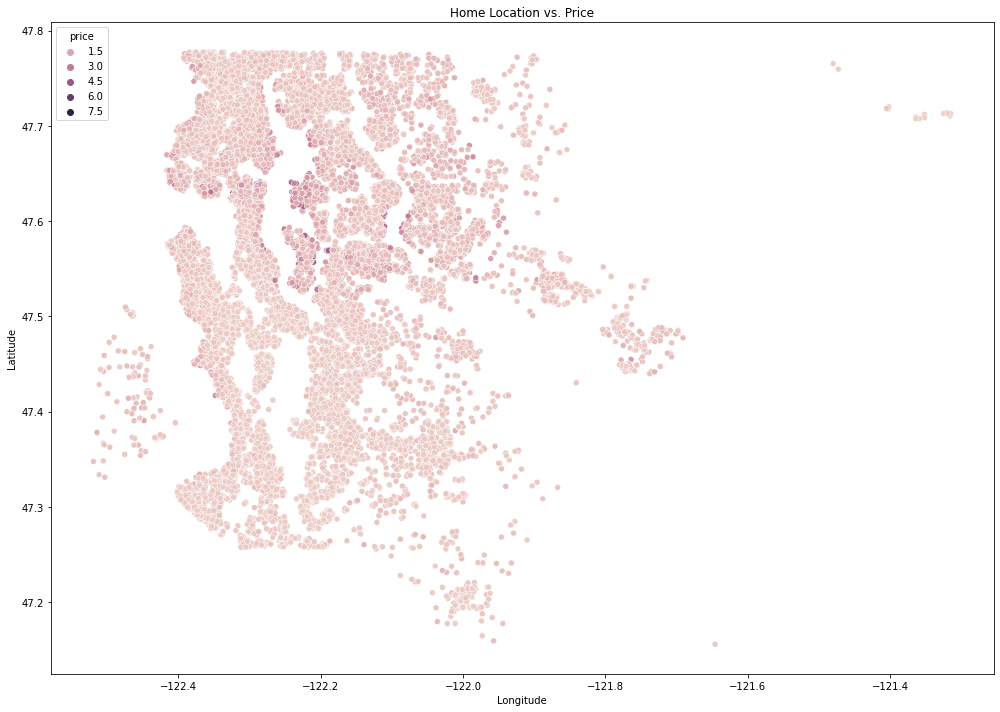

In [24]:
plt.figure(figsize=(14, 10))
plt.title('Home Location vs. Price')
sns.scatterplot(df['long'], df['lat'], hue=df['price'])#, palette='RdBu', alpha=0.3)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()

# Model 1 - Using All Features

###### X = df.drop('price', axis=1)
y = df['price']
model_1 = sm.OLS(y, sm.add_constant(X)).fit()
model_1.summary()

In [28]:
def clean_data_model_1(df):
    '''
    Takes in a pandas dataframe
    Applies cleaning methods for current project
    returns cleaned dataset
    '''
    
    # Fill NaN values with most commom occurances
    df['view'].fillna('NONE', inplace=True)
    df['waterfront'].fillna('NO', inplace=True)
    df['yr_renovated'].fillna(0.0, inplace=True)
    
    # Convert grade to int
    df['grade'] = df['grade'].apply(lambda x: x[:2] if x[0]=='1' else x[:1]).astype('int64')
    
    # Remove ? and convert sqft_basement to int
    df['sqft_basement'] = df['sqft_basement'].apply(lambda x: 0 if x=='?' else int(x.split('.')[0]))
    
    # Change waterfront to numeric
    df['waterfront'] = df['waterfront'].apply(lambda x: 1 if x=='YES' else 0)
    
    # Change view to numeric
    df['view'] = df['view'].apply(lambda x: 0 if x=='NONE' else (1 if x=='FAIR' else (2 if x=='AVERAGE' else (3 if x=='GOOD' else 4))))
    
    # Change condition to numeric
    df['condition'] = df['condition'].apply(lambda x: 1 if x=='Poor' else (2 if x=='Fair' else (3 if x=='Average' else (4 if x=='Good' else 5))))
    
    #Convert date column to 2 separate columns for month and year
    date = df['date'].str.split('/', expand=True)
    df['month_sold'] = date[0].astype('int64')
    df['year_sold'] = date[2].astype('int64')

    #Drop original date column
    df.drop(columns=['date'], axis=1, inplace=True)
    return df

ValueError: could not convert string to float: '10/13/2014'

In [30]:
to_clean = X_test
X_test['price'] = y_test

In [31]:
# Clean test according to cahnges so far
cleaned_X_test_1 = clean_data_model_1(to_clean)

In [32]:
y_test = cleaned_X_test_1['price']
X_test = cleaned_X_test_1.drop('price', axis=1)

In [34]:
LR = LinearRegression()
LR.fit(X,y)

ValueError: could not convert string to float: '10/13/2014'

In [33]:
y_prediction =  LR.predict(X_test)
y_prediction

NotFittedError: This LinearRegression instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [ ]:
rms = mean_squared_error(y_test, y_prediction, squared=False)

In [ ]:
rms

#### Our error so far is in near $200,000, which is not good for our model

# Checking our Assumptions

## Normality

In [ ]:
df.hist(figsize=(20,20));

None of these variables seem to follow a normal distribution. While this may create problems satisfying all assumptions, we'll first take a look at the other assumptions to see if there are any obvious changes to me made.

For now we'll use a QQ Plot to confirm that our assesment is correct.

In [ ]:
sns.distplot(model_1.resid);

In [ ]:
plt.figure(figsize=(12, 8))
fig = sm.graphics.qqplot(model_1.resid, dist=stats.norm, line='45', fit=True)
plt.title('QQ Plot')
plt.tight_layout();

In [ ]:
plt.figure(figsize=(12, 8))
plt.scatter(model_1.predict(), model_1.resid)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Checking for Homoscedasticity');

## Further EDA and dealing with some outliers and rounding decimals

In [ ]:
df['bedrooms'].value_counts()

In [ ]:
# Remove the few houses with high number of bedrooms
df = df[~df['bedrooms'].isin([11, 10, 9])]

#### Turn Bathrooms column into wc_comp and wc_inc:

In [ ]:
df['bathrooms'].value_counts()

In [ ]:
df['bathrooms'] = df['bathrooms'].apply(lambda x: np.ceil(x) if str(x)[2] == '7' else (np.ceil(x) if str(x)[2] == '5' else np.floor(x)))

In [ ]:
df['bathrooms'].value_counts()

In [ ]:
df = df[~df['bathrooms'].isin([8.0, 7.0])]

#### Changed Floor column:

In [ ]:
df['floors'].value_counts()

In [ ]:
df['floors'] = df['floors'].apply(lambda x: np.ceil(x))

# Model 2 - Changing features and removing outliers

In [ ]:
X = df.drop('price', axis=1)
y = df['price']
model_2 = sm.OLS(y, sm.add_constant(X)).fit()
model_2.summary()

In [ ]:
def clean_data_model_2(df):
    
    df = df[~df['bedrooms'].isin([11, 10, 9])]
    df['bathrooms'] = df['bathrooms'].apply(lambda x: np.ceil(x) if str(x)[2] == '7' else (np.ceil(x) if str(x)[2] == '5' else np.floor(x)))
    df = df[~df['bathrooms'].isin([8.0, 7.0])]
    df['floors'] = df['floors'].apply(lambda x: np.ceil(x))
    return df

In [ ]:
LR = LinearRegression()
LR.fit(X,y)

In [ ]:
LR = LinearRegression()
LR.fit(X,y)

to_clean = X_test
to_clean['price'] = y_test

# Clean test according to cahnges so far
cleaned_X_test_2 = clean_data_model_2(to_clean)

y_test = cleaned_X_test_2['price']
X_test = cleaned_X_test_2.drop('price', axis=1)

y_prediction =  LR.predict(X_test)
y_prediction

rms = mean_squared_error(y_test, y_prediction, squared=False)
rms

## Variable Correlations

In [ ]:
fig, ax = plt.subplots(figsize=(16, 16))
sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True);

In [ ]:
fig, ax = plt.subplots(figsize=(12, 10))
heatmap = sns.heatmap(df.corr()[['price']].sort_values(by='price', ascending=False), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Features Correlating with Price', fontdict={'fontsize':20}, pad=16);

Of the features most correlated with Price, a few of them are regarding to the size of the property and surrounding ones (sqft_living, sqft_living15, sqft_above, number of bathrooms)

In [ ]:
#visualizer = Rank2D(algorithm="pearson")
#visualizer.fit_transform(df)
#visualizer.show();

In [ ]:
# Drop some highly correlated columns
df.drop(['grade', 'sqft_above', 'sqft_living15', 'sqft_lot15'], axis=1, inplace=True)

In [ ]:
# Drop uncorrelated columns
df.drop(['id', 'year_sold', 'month_sold', 'zipcode'], axis=1, inplace=True)

# Model 3 - Addressing multicolinearity

In [ ]:
X = df.drop('price', axis=1)
y = df['price']
model_3 = sm.OLS(y, sm.add_constant(X)).fit()
model_3.summary()

In [ ]:
def clean_data_model_3(df):
    df.drop(['grade', 'sqft_above', 'sqft_living15', 'sqft_lot15'], axis=1, inplace=True)
    df.drop(['id', 'year_sold', 'month_sold', 'zipcode'], axis=1, inplace=True)
    return df

In [ ]:
LR = LinearRegression()
LR.fit(X,y)

to_clean = X_test
to_clean['price'] = y_test

# Clean test according to cahnges so far
cleaned_X_test_3 = clean_data_model_3(to_clean)

y_test = cleaned_X_test_3['price']
X_test = cleaned_X_test_3.drop('price', axis=1)

y_prediction =  LR.predict(X_test)
y_prediction

rms = mean_squared_error(y_test, y_prediction, squared=False)
rms

## Feature Engineering 1

In [ ]:
def distance_from(lat, long, series_lat, series_long):
    lat_long = series_lat.astype(str) + ',' + series_long.astype(str)
    lat_long = list(map(eval, lat_long))
    coordinates = (lat, long)
    miles = []
    for i in lat_long:
        miles.append(round(distance.distance(i, coordinates).miles, 1))
    series = pd.DataFrame(miles)
    return series

In [ ]:
# df['distance_seattle'] = distance_from(47.6062, -122.3321, df['lat'], df['long'])
# df['distance_redmond'] = distance_from(47.6740, -122.1215, df['lat'], df['long'])

In [ ]:
lat_long = df['lat'].astype(str) + ',' + df['long'].astype(str)
lat_long = list(map(eval, lat_long))
Seattle = (47.6062, -122.3321)
Redmond = (47.6740, -122.1215)
miles_s = []
miles_r = []
for i in lat_long:
    miles_s.append(round(distance.distance(i, Seattle).miles, 1))
for i in lat_long:
    miles_r.append(round(distance.distance(i, Redmond).miles, 1))
df['distance_seattle'] = miles_s
df['distance_redmond'] = miles_r

Since we created new columns using location information, we can drop the latitude, longitude and zipcode columns.

In [ ]:
df.drop(['lat', 'long'], axis=1, inplace=True)

In [ ]:
# Create column with rencent builds
df['recent_build'] = df['yr_built'].apply(lambda x: 1 if x > 2010 else 0)

In [ ]:
df.drop(['yr_built'], axis=1, inplace=True)

# Model 4 - With Feature Engineering Done

In [ ]:
X = df.drop('price', axis=1)
y = df['price']
model_4 = sm.OLS(y, sm.add_constant(X)).fit()
model_4.summary()

In [ ]:
def clean_data_model_4(df):
    
    lat_long = df['lat'].astype(str) + ',' + df['long'].astype(str)
    lat_long = list(map(eval, lat_long))
    Seattle = (47.6062, -122.3321)
    Redmond = (47.6740, -122.1215)
    miles_s = []
    miles_r = []
    for i in lat_long:
        miles_s.append(round(distance.distance(i, Seattle).miles, 1))
    for i in lat_long:
        miles_r.append(round(distance.distance(i, Redmond).miles, 1))
    df['distance_seattle'] = miles_s
    df['distance_redmond'] = miles_r
    
    df.drop(['lat', 'long'], axis=1, inplace=True)
    
    df['recent_build'] = df['yr_built'].apply(lambda x: 1 if x > 2010 else 0)
    df.drop(['yr_built'], axis=1, inplace=True)
    
    return df

In [ ]:
LR = LinearRegression()
LR.fit(X,y)

to_clean = X_test
to_clean['price'] = y_test

# Clean test according to cahnges so far
cleaned_X_test_4 = clean_data_model_4(to_clean)

y_test = cleaned_X_test_4['price']
X_test = cleaned_X_test_4.drop('price', axis=1)

y_prediction =  LR.predict(X_test)
y_prediction

rms = mean_squared_error(y_test, y_prediction, squared=False)
rms

## Extended EDA

In [ ]:
fig, ax = plt.subplots(figsize=(12, 10))
heatmap = sns.heatmap(df.corr()[['price']].sort_values(by='price', ascending=False), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Features Correlating with Price', fontdict={'fontsize':20}, pad=16);

In [ ]:
# Drop some highly correlated columns or with near zero correlation with price
df.drop(['condition', 'sqft_lot', 'yr_renovated', 'bathrooms', 'recent_build'], axis=1, inplace=True)

In [ ]:
# Drop outlier
df = df[df['price'] < 5000000]
df = df[df['sqft_basement'] < 3000]

## Model 5

In [ ]:
X = df.drop('price', axis=1)
y = df['price']
model_5 = sm.OLS(y, sm.add_constant(X)).fit()
model_5.summary()

In [ ]:
LR = LinearRegression()
LR.fit(X,y)


In [ ]:
# features = np.array([bedrooms, sqft_living, floors, waterfront, view, sqft_basement, distance_seattle, distance_redmond], dtype=float)

features = np.array([3, 15, 10, 1, 0, 650, 6.3, 9.6], dtype=float)

formula = LR.intercept_ + (np.dot(LR.coef_, features))
formula

In [ ]:
formula

In [ ]:
LR = LinearRegression()
LR.fit(X,y)
plot.scatter(X,y)

In [ ]:
Seattle = (47.6062, -122.3321)
Redmond = (47.6740, -122.1215)

In [ ]:
fig, ax = plt.subplots(figsize=(14, 10))
plt.title('Home Location vs. Price')
sns.scatterplot(df_ref['long'], df_ref['lat'], hue=df['distance_redmond'])#, palette='RdBu', alpha=0.3)
# sns.scatterplot(47.6062, -122.3321)#, color='g', marker='*')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()

In [ ]:
y_test

In [ ]:
X_test

In [ ]:
LR.intercept_

In [ ]:
print("Final Regression Formula\n")
print(model.intercept_, '+')
print('sum(')
for i in range(len(model_coefficients)):
    print(model_coefficients.coefficients[i], '*', model_coefficients.index[i])
print(')')


In [ ]:
def clean_data_model_5(df):
    df.drop(['condition', 'sqft_lot', 'yr_renovated', 'bathrooms', 'recent_build'], axis=1, inplace=True)
    df = df[df['price'] < 4000000]
    df = df[df['sqft_basement'] < 3000]
    
    return df

In [ ]:
LR = LinearRegression()
LR.fit(X,y)

to_clean = X_test
to_clean['price'] = y_test

# Clean test according to cahnges so far
cleaned_X_test_5 = clean_data_model_5(to_clean)

y_test = cleaned_X_test_5['price']
X_test = cleaned_X_test_5.drop('price', axis=1)

y_prediction =  LR.predict(X_test)
y_prediction

rms = mean_squared_error(y_test, y_prediction, squared=False)
rms

In [ ]:
LR.score(X_test, y_test) #r-squared

In [ ]:
np.exp(y).mean()

In [ ]:
plt.scatter(y_test, y_prediction)

In [ ]:
sns.regplot(y_test, y_prediction)

In [ ]:
def model_diagnostic(model, x, x_name, y):
    
    residuals = model.resid
    
    f = plt.figure()
    f, axes = plt.subplots(nrows = 1, ncols = 3, sharex=False, sharey = False, figsize=(65,20), squeeze=False)
    
    f.text(s="Model Diagnostic Summary", x=.40, y=1.15, fontsize=65, fontname='silom')
    f.text(s="r-Squared: {r}".format(r=round(model.rsquared, 2)), x=.40, y=1.05, fontsize=50, fontname='serif')
    f.text(s="p-value: {p}".format(p= model.f_pvalue), x=.53, y=1.05, fontsize=50, fontname='serif')
    
    f.text(s='Residuals Histogram', x=.45, y=.93, fontsize=55, fontname='serif')
    
    sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True, ax=axes[0][0])    
    plt.show;
    
    f.text(s='QQ Plot', x=.20, y=.93, fontsize=55, fontname='serif')
    
    axes[0][1].hist(residuals)
    plt.show;
    
    sns.residplot(x, y, ax=axes[0][2])
    
 
    f.text(s='Residuals vs {x}'.format(x=x_name), x=.73, y=.93, fontsize=55, fontname='serif')
    plt.tight_layout;
    plt.show;

In [ ]:
def model_diagnostic(model, x, x_name, y):
    
    residuals = model.resid
    fig, axes = plt.subplots(nrows = 1, ncols = 3, sharex=False, sharey = False, figsize=(65,20), squeeze=False)

    sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True, ax=axes[0][0])      
    axes[0][1].hist(residuals)
    sns.residplot(x, y, ax=axes[0][2])
    plt.tight_layout;

### Transformations

In [ ]:
df['price'] = np.log(df['price'])
# df['log_bedrooms'] = np.log(df['bedrooms'])
# df['log_bathrooms'] = np.log(df['bathrooms'])
# df['log_sqft_living'] = np.log(df['sqft_living'])
# df['log_floors'] = np.log(df['floors'])
# df['log_waterfront'] = np.log(df['waterfront'])
# df['log_view'] = np.log(df['view'])
# df['log_distance_seattle'] = np.log(df['distance_seattle'])
# df['log_distance_redmond'] = np.log(df['distance_redmond'])

In [ ]:
# df.drop(['log_distance_redmond', 'log_distance_seattle'], axis=1, inplace=True)

In [ ]:
# df.drop(['log_view'], axis=1, inplace=True)

In [ ]:
# df.drop(['log_bathrooms'], axis=1, inplace=True)

In [ ]:
# df['log_distance_redmond'] = np.log(df['distance_redmond'])

In [ ]:
# df['log_distance_seattle'] = np.log(df['distance_seattle'])

In [ ]:
# df['log_view'] = np.log(df['view'])

In [ ]:
X = df.drop('price', axis=1)
y = df['price']
model_6 = sm.OLS(y, sm.add_constant(X)).fit()
model_6.summary()

In [ ]:
def clean_data_model_6(df):
    df['price'] = np.log(df['price'])

    return df

In [ ]:
LR = LinearRegression()
LR.fit(X,y)

to_clean = X_test
to_clean['price'] = y_test

# Clean test according to cahnges so far
cleaned_X_test_6 = clean_data_model_6(to_clean)

y_test = cleaned_X_test_6['price']
X_test = cleaned_X_test_6.drop('price', axis=1)

y_prediction =  LR.predict(X_test)
y_prediction

rms = mean_squared_error(y_test, y_prediction, squared=False)
rms

In [ ]:
this is to break the code

In [ ]:
sns.scatterplot(y_prediction, y_test)

In [ ]:
plt.errorbar(y_prediction, y_test, yerr=dy, fmt='.k');
sns.lmplot(x="size", y="tip", data=tips, x_estimator=np.mean);

In [ ]:
def normalize(feature):
    return (feature - feature.mean()) / feature.std()

In [ ]:
features_final = ames_log.apply(normalize)

In [ ]:
df.keys()

In [ ]:
for feature in df.keys():
    if feature.startswith('log'):
        df[feature] = normalize(df[feature])


In [ ]:
X = df.drop('price', axis=1)
y = df['price']
model_7 = sm.OLS(y, sm.add_constant(X)).fit()
model_7.summary()

In [ ]:
f = 'price~sqft_living'
sqft_living_model = smf.ols(formula=f, data=df).fit()
residuals = sqft_living_model.resid
plt.figure(figsize=(12, 8))
fig = sm.graphics.qqplot(sqft_living_model.resid, dist=stats.norm, line='45', fit=True)
plt.title('QQ Plot')
plt.tight_layout();

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(sqft_living_model.predict(), sqft_living_model.resid)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Checking for Homoscedasticity');

In [ ]:
sns.distplot(sqft_living_model.resid);

In [ ]:
f = 'price~bedrooms'
bedrooms_model = smf.ols(formula=f, data=df).fit()
model_diagnostic(bedrooms_model, df['bedrooms'], 'bedrooms', df['price'])

In [ ]:
f = 'price~bathrooms'
bathrooms_model = smf.ols(formula=f, data=df).fit()
model_diagnostic(bathrooms_model, df['bathrooms'], 'bathrooms', df['price'])

In [ ]:
f = 'price~sqft_living'
sqft_living_model = smf.ols(formula=f, data=df).fit()
model_diagnostic(sqft_living_model, df['sqft_living'], 'sqft_living', df['price'])

In [ ]:
f = 'price~floors'
floors_model = smf.ols(formula=f, data=df).fit()
model_diagnostic(floors_model, df['floors'], 'floors', df['price'])

In [ ]:
f = 'price~waterfront'
waterfront_model = smf.ols(formula=f, data=df).fit()
model_diagnostic(waterfront_model, df['waterfront'], 'waterfront', df['price'])

In [ ]:
f = 'price~sqft_basement'
sqft_basement_model = smf.ols(formula=f, data=df).fit()
model_diagnostic(sqft_basement_model, df['sqft_basement'], 'sqft_basement', df['price'])

In [ ]:
f = 'price~distance_seattle'
distance_seattle_model = smf.ols(formula=f, data=df).fit()
model_diagnostic(distance_seattle_model, df['distance_seattle'], 'distance_seattle', df['price'])

In [ ]:
f = 'price~distance_redmond	'
distance_redmond_model = smf.ols(formula=f, data=df).fit()
model_diagnostic(distance_redmond_model, df['distance_redmond'], 'distance_redmond', df['price'])

In [ ]:
X = df.drop('price', axis=1)
y = df['price']
model = sm.OLS(y, sm.add_constant(X)).fit()
model.summary()

In [ ]:
sns.distplot(model_5.resid);

In [ ]:
fig = sm.graphics.qqplot(model_5.resid, dist=stats.norm, line='45', fit=True)

In [ ]:
plt.figure(figsize=(12, 8))
plt.scatter(model.predict(), model.resid)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Checking for Homoscedasticity')

## Validating the Model

We fail to reject the null hypotesis here since the p-value is insignificant, so the model is homoscedastic.

In [ ]:
fig, ax = plt.subplots(figsize=(12, 10))
heatmap = sns.heatmap(df.corr()[['price']].sort_values(by='price', ascending=False), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Features Correlating with Price', fontdict={'fontsize':20}, pad=16);

## Checking Assumptions for Linear Regression

## sns.pairplot(df, y_vars=['price'])

In [ ]:
plt.scatter(x=df['sqft_living']**2, y=df['price'])

In [ ]:
df['sqft_living']**2

In [ ]:
# X = df.drop('price', axis=1)
for col in X.columns:
    plt.subplots(1, 1)
    sns.regplot(X[col], df.price)
    plt.title(col)

In [ ]:
from sklearn.svm import SVC
from sklearn.datasets import make_classification

from yellowbrick.model_selection import RFECV

# Instantiate RFECV visualizer with a linear SVM classifier
visualizer = RFECV(SVC(kernel='linear', C=1))

visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Description of King's Housing Data Columns

* `id` - Unique identifier for a house
* `date` - Date house was sold
* `price` - Sale price (prediction target)
* `bedrooms` - Number of bedrooms
* `bathrooms` - Number of bathrooms
* `sqft_living` - Square footage of living space in the home
* `sqft_lot` - Square footage of the lot
* `floors` - Number of floors (levels) in house
* `waterfront` - Whether the house is on a waterfront
  * Includes Duwamish, Elliott Bay, Puget Sound, Lake Union, Ship Canal, Lake Washington, Lake Sammamish, other lake, and river/slough waterfronts
* `view` - Quality of view from house
  * Includes views of Mt. Rainier, Olympics, Cascades, Territorial, Seattle Skyline, Puget Sound, Lake Washington, Lake Sammamish, small lake / river / creek, and other
* `condition` - How good the overall condition of the house is. Related to maintenance of house.
  * See the [King County Assessor Website](https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r) for further explanation of each condition code
* `grade` - Overall grade of the house. Related to the construction and design of the house.
  * See the [King County Assessor Website](https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r) for further explanation of each building grade code
* `sqft_above` - Square footage of house apart from basement
* `sqft_basement` - Square footage of the basement
* `yr_built` - Year when house was built
* `yr_renovated` - Year when house was renovated
* `zipcode` - ZIP Code used by the United States Postal Service
* `lat` - Latitude coordinate
* `long` - Longitude coordinate
* `sqft_living15` - The square footage of interior housing living space for the nearest 15 neighbors
* `sqft_lot15` - The square footage of the land lots of the nearest 15 neighbors

Ignore

date
view
sqft_above
sqft_basement
yr_renovated
zipcode
lat
long
sqft_living15
sqft_lot15

In [ ]:
house_data = pd.read_csv('data/kc_house_data.csv')
house_data

In [ ]:
sns.pairplot(house_data)


In [ ]:
sns.pairplot(house_data,  y_vars=['price'])

In [ ]:
sns.heatmap(house_data.corr())

In [ ]:
x = ['bedrooms','bathrooms','sqft_living', 'sqft_lot', 'sqft_above']
y = ['price']
test_model = sm.OLS(house_data[y],sm.add_constant(house_data[x])).fit()
model_summary = test_model.summary()
model_summary

In [ ]:
rsquare_1 = 0.703
rsquare_2 = 0.704
rsquare_3= 0.655
rsquare_4 = 0.688
rsquare_5 = 0.680

rms_1 = 199177.32750300417
rms_2 = 199811.68761176738
rms_3 = 211769.47140901658
rms_4 = 201361.78148826104
rms_5 = 191685.177168897

In [ ]:
x_rms = ["Model 1", "Model 2", "Model 3", "Model 4", "Model 5"]
y_rms = [199177.32750300417,199811.68761176738, 211769.47140901658, 201361.78148826104, 191685.177168897]

In [ ]:
sns.barplot(x = x_rms, y = y_rms)

#### Auburn School District
Alpac Elementary - 310 Milwaukee Boulevard, North Pacific, WA 98047
Arthur Jacobsen Elementary - 29205 132nd Avenue Southeast, Auburn, WA 98092

Auburn High School
711 East Main Street
Auburn, WA 98002

Auburn Mountainview High School
28900 124th Avenue Southeast
Auburn, WA 98092

Auburn Riverside High School
501 Oravetz Road
Auburn, WA 98092

Bowman Creek Elementary
5701 Kersey Way SE
Auburn, WA 98092

Cascade Middle School
1015 24th Street NE
Auburn, WA 98002

Chinook Elementary
1825 K Street SE - Temp Address: 2021-22
Auburn, WA 98002

Dick Scobee Elementary
1031 14th Street NE
Auburn, WA 98002

Evergreen Heights Elementary
5602 South 316th
Auburn, WA 98001

Gildo Rey Elementary
1005 37th Street SE
Auburn, WA 98002


Hazelwood Elementary
11815 SE 304th Street
Auburn, WA 98092

Ilalko Elementary
301 Oravetz Place SE
Auburn, WA 98092



Lake View Elementary
16401 SE 318th
Auburn, WA 98092

Lakeland Hills Elementary
1020 Evergreen Way SE
Auburn, WA 98092


Lea Hill Elementary
13002 SE 304th Street - Temp Address: 2021-22
Auburn, WA 98092

Mt. Baker Middle School
620 37th Street SE
Auburn, WA 98002

Olympic Middle School
839 21st Street SE
Auburn, WA 98002


Pioneer Elementary
2301 M Street SE
Auburn, WA 98002

Rainier Middle School
30620 116th Avenue SE
Auburn, WA 98092

Terminal Park Elementary
1101 D Street SE
Auburn, WA 98002

Washington Elementary
20 E Street NE
Auburn, WA 98002

West Auburn High School
401 West Main Street
Auburn, WA 98001

#### Bellevue School District
Ardmore
Ardmore Elementary School
16616 NE 32nd Street, Bellevue, WA 98008

Bennett
Bennett Elementary School
 17900 NE 16th St, Bellevue, WA 98008
 
 
Cherry Crest
Cherry Crest Elementary
 12400 NE 32nd Street, Bellevue, WA 98005
 
Clyde Hill
Clyde Hill Elementary
 9601 NE 24th St., Bellevue, WA 98004
 
Eastgate
Eastgate Elementary
 4255 153rd Ave SE, Bellevue, WA 98006
 
Enatai
Enatai Elementary School
 10700 SE 25th Street, Bellevue, WA 98004
 
Lake Hills
Lake Hills Elementary
 14310 SE 12th Street, Bellevue, WA 98007
 
 Medina
Medina Elementary
 8001 NE 8th Street, Medina, WA 98039
 
 Newport Heights
Newport Heights Elementary
 5225 119th Ave SE, Bellevue, WA 98006
 
 Phantom Lake
Phantom Lake Elementary
 1050 160th Ave SE, Bellevue, WA 98008
 
 Sherwood Forest
Sherwood Forest Elementary
 16411 NE 24th Street, Bellevue, WA 98008
 
 
 Somerset
Somerset Elementary
 14100 Somerset Blvd SE, Bellevue, WA 98006
 
 
 Spiritridge
Spiritridge Elementary
 16401 SE 24th Street, Bellevue, WA 98008
 
 Stevenson
a photo of the entrance to Stevenson Elementary
 14220 NE 8th St, Bellevue, WA 98007
 
 Wilburton
Wilburton Elementary School
 12300 Main Street, Bellevue, WA 98005
 
 
 Woodridge
Woodridge Elementary
 12619 SE 20th Place, Bellevue, WA 98005


Chinook
Chinook Middle School
 2001 98th Ave NE, Bellevue, WA 98004
 
 Highland
Highland Middle School front entrance.
 15027 NE Bel/Red Road, Bellevue, WA 98007
 
 Odle
Odle Middle School
 502 143rd Ave NE, Bellevue, WA 98007
 
 Tillicum
Tilicum Middle School
 1280 160th Ave SE, Bellevue, WA 98008
 
 Tyee
Tyee Middle School
 13630 SE Allen Road, Bellevue, WA 98006
 
 Bellevue
Bellevue High School
 10416 SE Wolverine Way, Bellevue, WA 98004
 
 Interlake
Interlake High School
 16245 NE 24th Street, Bellevue, WA 98008
 
 Newport
Newport High School
 4333 Factoria Blvd SE, Bellevue, WA 98006
 
 Sammamish
Sammamish High School
 100 140th Ave SE, Bellevue, WA 98005
 

#### EnumClaw School District
#### Federal Way School District

Elementary
Adelaide Elementary    Facebook
adelaide elementary

1635 S.W. 304th St.
Federal Way, WA 98023
Phone: (253) 945-2300

Brigadoon Elementary
brigadoon elementary

3601 S.W. 336th Street
Federal Way, WA 98023
Phone: (253) 945-2400

Camelot Elementary
camelot

4041 S. 298th St
Auburn, WA 98001
Phone: (253) 945-2500

Enterprise Elementary
enterprise

35101 5th Avenue SW
Federal Way, WA 98023
Phone: (253) 945-2600

Green Gables Elementary
green gables elementary

32607 47th Avenue S.W.
Federal Way, WA 98023
Phone: (253) 945-2700

Lake Dolloff Elementary
lake dolloff elementary

4200 S. 308th Street
Auburn, WA 98001
Phone: (253) 945-2800

Lake Grove Elementary
lg icon 

303 S.W. 308th Street
Federal Way, WA 98023
Phone: (253) 945-2900

 

Lakeland Elementary
lakeland 

35827 32nd Avenue S.
Auburn, WA 98001
Phone: (253) 945-3000

Mark Twain Elementary
Mark Twain

2450 S. Star Lake Road
Federal Way, WA 98003
Phone: (253) 945-3100

Meredith Hill Elementary    Facebook
meredith

5830 S. 300th Street
Auburn, WA 98001
Phone: (253) 945-3200

Mirror Lake Elementary
mirrorlake

625 S. 314th Street
Federal Way, WA 98003
Phone: (253) 945-3300

Nautilus K-8
nautilus

1000 S. 289th Street
Federal Way, WA 98003
Phone: (253) 945-3400

Olympic View Elementary     Facebook
Olympic View

Currently Under Construction

2626 S.W. 327th Street
Federal Way, WA 98023
Phone: (253) 945-3500

Temporarily Relocated to:

3600 S 344th Way 
Federal Way, WA 98001

Panther Lake Elementary
panther lake elementary

34424 1st Avenue S.
Federal Way, WA 98003
Phone: (253) 945-3600

Rainier View Elementary
rainier view 

3015 S. 368th Street
Federal Way, WA 98003
Phone: (253) 945-3700

Sherwood Forest Elementary
Sherwood Forest

34600 12th Avenue S.W.
Federal Way, WA 98023
Phone: (253) 945-3800

Silver Lake Elementary
silver lake

1310 S.W. 325th Place
Federal Way, WA 98023
Phone: (253) 945-3900

Star Lake Elementary     Facebook
starlake

Currently Under Construction

4014 S. 270th Street
Kent, WA 98032
Phone: (253) 945-4000

Temporarily Relocated to:

3600 S 344th Way 
Federal Way, WA 98001

 

Sunnycrest Elementary
sunnycrest

24629 42nd Ave. S.
Kent, WA 98032
Phone: (253) 945-4100

Twin Lakes Elementary
twin lakes

4400 S.W. 320th St.
Federal Way, WA 98023
Phone: (253) 945-4200

Valhalla Elementary Facebook
valhalla

27847 42nd Avenue S.
Auburn, WA 98001
Phone: (253) 945-4300

Please contact the school regarding uniform policy.

Wildwood Elementary
Wildwood Front 

2405 S. 300th St
Federal Way, WA 98003
Phone: (253) 945-4400

Woodmont K-8
woodmont

26454 16th Avenue S.
Des Moines, WA 98198
Phone: (253) 945-4500



#### Highline School District


#### Issaquah School District
Apollo Elementary - (425) 837-7500
15025 SE 117th St, Renton, WA - From I-90 take exit #15 and go south on the Renton-Issaquah Road (SR-900). Turn left onto 148th SE, left onto 117th SE, and continue to the school.

Briarwood Elementary - (425) 837-5000
17020 SE 134th St, Renton, WA - From I-90 take exit #15 and go south on the Renton-Issaquah Road (SR-900). Turn left onto 164th Ave. SE, left onto SE 128th, right on 168th, left on 134th and continue to the school.

Cascade Ridge Elementary - (425) 837-5500
2020 Trossachs Blvd SE, Sammamish, WA - From I-90 eastbound take exit #18 and stay to the left onto Highland Drive. Turn right onto Issaquah-Fall City Rd. at stoplight. Bear left as Issaquah-Fall City Rd. becomes Duthie Hill Rd. Turn left onto Trossachs Blvd. SE. School is on the right.

Cedar Trails Elementary - (425) 837-6500
4399 Issaquah-Pine Lake Road SE, Sammamish, WA - From I-90 eastbound take exit #18 and stay to the left onto Highland Drive. Continue on Highland Drive as it becomes Issaquah-Pine Lake Rd. approximately 1 mile.  School is on the left before Klahanie Blvd.

Challenger Elementary - (425) 837-7550
25200 SE Klahanie Blvd, Sammamish, WA -  From I-90 eastbound take exit #18 and stay to the left onto Highland Drive. Continue on Highland Drive as it becomes Issaquah-Pine Lake Rd. Turn right at the light onto Klahanie Blvd. Continue on Klahanie Blvd. approximately 1 mile.

Clark Elementary - (425) 837-6300
500 2nd Ave SE, Issaquah, WA - From I-90 take exit #17. Go south on Front Street turn left at the stop light onto E. Sunset Way. Turn right onto 2nd Ave. SE and continue, school is on the left. 

Cougar Ridge Elementary - (425) 837-6400
4630 167th Ave SE, Bellevue, WA - From 1-90 eastbound take exit 13, stay to right. At stoplight go straight on Lakemont Blvd for 1 mile. At stoplight at Lakemont and 171st SE, make a right turn.  Continue for .4 mile. At SE 47th St., turn left, continue on SE 47th, which becomes SE 46th. Take first left turn into the school.

Creekside Elementary - (425) 837-5200
20777 SE 16th St, Sammamish, WA - From 1-90 take exit 17. Turn left on Front St. Take a left on East Lake Sammamish Pkwy, go 2 miles and take right at round about (43rd). Continue on 43rd until it turns into 228th Ave. SE. Go thru stoplight, continue ½ mile and turn left on SE 20th St. Travel one mile and turn right on 212th Ave. SE. Turn left on 18th SE, then right onto SE 16th.

Discovery Elementary - (425) 837-4100
2300 228th Ave SE, Sammamish, WA - From I-90 take exit #17. Go north on E. Lake Sammamish Road, turn right at the light at E. 43rd Way which turns into 228th Ave SE.  Continue on 228th until you reach the school on your right.

Endeavour Elementary - (425) 837-7350
26205 SE Issaquah Fall City Rd, Issaquah, WA -  From I-90 eastbound, take exit #18 and stay to the left onto Highland Drive. Turn right onto Issaquah-Fall City Rd. at stoplight. Bear left as Issaquah-Fall City Rd. becomes Duthie Hill Road. The school is on the right.

Grand Ridge Elementary - (425) 837-7925
1739 NE Park Dr, Issaquah, WA -  From I-90 take the new Sunset Interchange (Exit #18). Follow Highlands Drive up the hill and turn right on NE Federal Dr., then turn right on NE Park Dr. Continue .8 mile.  From the Plateau, drive south on Issa-Pine Lake Road, across Issaquah-Fall City Rd where Highlands Dr begins. Turn left on NE Federal Dr., right on NE Park Dr.

Issaquah Valley Elementary - (425) 837-6600
555 NW Holly St, Issaquah, WA - From I-90 take exit #15 , go south on Renton-Issaquah Rd (SR-900). Turn left onto Maple, it becomes Newport Way.. Turn left onto Holly St. 

Maple Hills Elementary - (425) 837-5100
15644 204th Ave SE, Renton, WA - From I-90 take exit 15, go west (right) on the Renton-Issaquah Road (SR-900), about 4 miles. At stoplight, turn left on SE May Valley Road and go until flashing red light, turn right on SE 128th Way and go about ¾ of a mile. At top of hill take sharp left onto 196th Ave SE and go about 1.5 miles (after about a mile, road curves left and changes to SE 150th St., then curves right and changes to SE 152nd). At Community Park, turn right onto 204th Ave SE and continue 2 blocks to the school.

Newcastle Elementary - (425) 837-5800
8400 136th Ave SE, Newcastle, WA - From 405, take exit #10 onto Coal Creek Parkway SE.   Go east on Coal Creek for approx. 3 miles to 135th Ave SE. Turn left on 135th Ave SE, turn left on 136th Ave SE, turn right into parking lot of school. From Issaquah, go south on SR 900/Issa-Renton Rd, approximately 8 miles. Turn right on Duval Ave NE (Duval changes into Coal Creek Parkway at Newcastle City limits) travel 1.7 miles to 135th Ave Se. Turn right onto 135th Ave SE, turn left on 136th Ave SE, turn right into parking lot of school.

Sunny Hills Elementary - (425) 837-7400
3200 Issaquah Pink Lake Road SE, Sammamish, WA - From I-90 eastbound, take exit #18 and stay to the left onto Highland Drive. Continue on Highland Drive as it becomes Issaquah-Pine Lake Rd. Continue on Issaquah-Pine Lake Rd. for about 3 miles. The school is on the right.

Sunset Elementary - (425) 837-5600
4229 W Lake Sammamish Pkwy SE, Bellevue, WA - From I-90 take exit #13. The school is on the north side of the freeway.


Beaver Lake Middle School - (425) 837-4150
25025 SE 32nd St, Sammamish, WA - From I-90 eastbound, take exit #18 and stay to the left onto Highland Drive. Continue on Highland Drive as it becomes Issaquah-Pine Lake Rd. Continue on Issaquah-Pine Lake Rd. for about 3 miles. Turn right on 32nd Way. The school will be on your right.

Cougar Mountain Middle School - (425) 837-6700
Temporary Campus: 11650 SE 60th Street, Bellevue, WA 

From I-90 westbound, take exit #9 for I-405 South towards Renton. Continue on I-405 South for about two miles and take exit #9 toward 112th Ave SE/Newcastle. Turn left onto Lake Washington Blvd SE, the turn left onto SE 60th St. Ringdall Junior High School will be on your left.

From the Newcastle and May Valley area, head northbound on Coal Creek Parkway and turn left onto SE 60th St. Ringdall Junior High School will be on your right.

Permanent Campus: 1929 NW Talus Drive, Issaquah, WA 

From I-90 eastbound, take exit #15 and turn right at the exit onto WA-900/17th Ave NW. Continue on WA-900 for about half a mile and turn right onto NW Talus Dr. Turn left into the school entrance.

From the Newcastle and May Valley area, head southbound on Coal Creek Parkway and turn left onto SE May Valley Rd. Turn left onto WA-900 E/Renton Issaquah Rd SE and continue for just over 4 miles. Turn left on NW Talus Dr and turn left into the school entrance.

Issaquah Middle School - (425) 837-6800
600 2nd Ave SE, Issaquah, WA - From I-90 take exit #17 and head south on Front Street. Turn left at the stop light onto E. Sunset Way. Turn right on 2nd Ave. SE and take a left at the light into Issaquah High School. Issaquah Middle School will be on the left.

Maywood Middle School - (425) 837-6900
14490 168th Ave SE, Renton, WA - From I-90 take exit #15 and go south on the Renton-Issaquah Road (SR-900). Turn left onto 164th Ave. SE, left onto SE 128th, right onto 168th SE, left onto SE 136th, right onto 169th SE, right onto 144th SE, left at 168th.

Pacific Cascade Middle School - (425) 837-5900
24635 SE Issaquah Fall City Rd, Issaquah, WA - From 1-90 eastbound, take exit #18 and stay to the left onto Highland Drive. Turn right onto Issaquah-Fall City Rd. at stoplight. Go about ½ mile until 247th SE, turn right. School is right there.

Pine Lake Middle School - (425) 837-5700
3095 Issaquah-Pine Lake Road SE, Sammamish, WA - From I-90 eastbound, take exit #18 and stay to the left onto Highland Drive. Continue on Highland Drive as it becomes Issaquah-Pine Lake Rd. Continue on Issaquah-Pine Lake Rd. for about 3 miles. The school is on the left.

Gibson Ek High School - (425) 837-6350
379 1st Pl SE, Issaquah, WA - (formerly Issaquah Middle School) - From I-90 take #17 and proceed south onto Front Street. Continue south on Front Street into downtown Issaquah. Turn left on Clark. Go past the Boehm Pool on the left into the school parking lot.

Issaquah High School - (425) 837-6000
700 2nd Ave SE, Issaquah, WA -  From I-90 take exit #17 and head south on Front Street. Turn left at the stop light onto E. Sunset Way. Turn right on 2nd Ave. SE and continue to the school which is on the left.

Liberty High School - (425) 837-4800
16622 SE 136th St, Renton, WA - From I-90 take exit #15 and go south on the Renton-Issaquah Road (SR-900). Turn left onto 164th Ave. SE, left onto SE 128th, right onto 168th SE. The school is located on the corner of 168th and 136th.

Skyline High School - (425) 837-7700
1122 228th Ave SE, Sammamish, WA - From I-90 take exit #17. Go north on E. Lake Sammamish Road. Turn right at the light onto SE 43rd way which turns into 228th Ave SE. Continue on 228th to the school which is on the right.

Echo Glen School - (425) 831-2520
33010 SE 99th St, Snoqualmie, WA - From I-90 take exit #25 and go toward ramp onto Highway 18/Snoqualmie Parkway.  Turn left onto Hwy 18 (road changes to Snoqualmie Pkwy) and left onto SE 99th. 


#### Kent School District
Cedar_Heights
Mattson
Meeker
Meridian
Mill
Northwood


#### Lake Washington School District
#### Mercer Island School District
#### Northshore School District
#### Renton School District
#### Riverview School District
####  Seattle Public Schools
#### Shoreline School District
####  Snoqualmie Valley School District
#### Tahoma School District
#### Tukwila School District
#### Vashion Island School District